# single frame'spine instances by unet2d model


In [2]:
# import library 导入库文件
import sys
import tifffile
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from skimage.io import imsave
from skimage.morphology import remove_small_objects
InteractiveShell.ast_node_interactivity = 'last_expr'
from tqdm import tqdm
import numpy as np
import os


sys.path.append("..")
sys.path.append("..//..")

from IPython.core.interactiveshell import InteractiveShell
from skimage.filters import threshold_otsu, threshold_yen
from skimage.filters.thresholding import (threshold_isodata, threshold_li,
                                          threshold_local, threshold_mean,
                                          threshold_minimum,
                                          threshold_multiotsu,
                                          threshold_niblack, threshold_otsu,
                                          threshold_triangle, threshold_yen)
from skimage.io import imsave
from skimage.morphology import remove_small_objects
from skimage.segmentation import expand_labels, watershed
from utils import file_base
import spinelib
from spinelib import cflow, imgio, seg
from spinelib.cflow.blob import find_spheres, peakfilter, sphere_log
from spinelib.cflow.localthreadhold import local_threshold
from spinelib.imgio import napari_base
from spinelib.seg import segment, track,unetseg
from spinelib.utils import npixel
from spinelib.utils.measure import label_statics
from spinelib.utils.spine_struct import spines_distance
from spinelib.imgio import imgio_base
from spinelib.imgio.imgio_base import savelabel,savepr
from utils import file_base,yaml_config
from train.trainers import predict
# InteractiveShell.ast_node_interactivity = 'last_expr'
methods = cflow.localthreadhold.thmethods


No Fortran modules found, falling back on Python implementation.
Did you run `python3 setup.py install`?


In [3]:
# super params
#-----------------------#
#   paras  #
#-----------------------#
# 设置载入2D/3D  参数
paras_2D=dict(
    axes="xy", #2D
    sigma=(2,2), # 2D y,x
    steps=2, # caculate stick gradient step lenth 1-4, larger more error , smaller than spine diameter
    lambda1=1,
    lambda2=1.5, # lambda2 need large than lambda1
    sigma_hessian = 4,
    sigma_supp = 100,
    countth=10*20 ,# fiber largest pixels, include z stack, that to say lenth*stackn
    smallobj=200,
    spine_radius=35, # for iteration to growth area
    min_radius=3,
    maxspinesize=600,
    spotrange=[3,11],
    binary_func=threshold_li, # local_threshold  #threshold_li
    use_sobel=False,
    search_box=[25,25],
    keep_time=5,
    peak_use_gaussian=True,
    spine_min_size_th=4, 
    searchbox=[5,5],
)
paras_3D=dict(
    axes="zxy", #
    sigma=(2,2,2), # y,x
    steps=2, # caculate stick gradient step lenth 1-4, larger more error , smaller than spine diameter
    lambda1=1,
    lambda2=1.5, # lambda2 need large than lambda1
    sigma_hessian = 4,
    sigma_supp = 100,
    countth=10*20 ,# fiber largest pixels, include z stack, that to say lenth*stackn
    smallobj=200,
    spine_radius=35, # for iteration to growth area
    min_radius=3,
    maxspinesize=200,
    spotrange=[3,11],
    binary_func=threshold_li, # local_threshold  #threshold_li
    use_sobel=False,
    search_box=[25,25],
    keep_time=5,
    peak_use_gaussian=True,
    spine_min_size_th=4, 
    searchbox=[5,5,5]
)


In [4]:
#-----------------------#
#   model loader  #
#-----------------------#
# 选择使用的配置文件,用于载入预测模型和参数

configfile=r"..\config\defalut_2d_border.yaml"
default_configuration=yaml_config.YAMLConfig(
        configfile
        )
premodel=r"E:\code\test-dataset\model\2Dtorchunet3-b\seg\ep050-loss0.428.pth"
# modelpath=r"D:\code\myspine\models\defaultmodel\actin-modelep006-loss0.097.h5"
# modelpath=r"D:\code\myspine\models\defaultmodel\morph-modelep200-loss0.133.h5"
# modelpath=r"D:\code\test-dataset\model\2D\segep064-loss0.125.h5"

predictmodel = predict.Predict()

predictmodel.setting(default_configuration,use_gpu=False)
predictmodel.load_weight(False,premodel)


2023-04-22 20:02:57,571 - ..\train\trainers\predict.py[line:95] - INFO: 
==============LOAD PRETRAINED model==============
E:\code\test-dataset\model\2Dtorchunet3-b\seg\ep050-loss0.428.pth



relative rootdir :	 E:\data\Train\Train\2D-2023-border
absolute rootdir :	 E:\data\Train\Train\2D-2023-border
e:\code\myspine-20230406-torch\test-dataset\log\2Dtorchunet3-b\seg\train_info.log
device: cpu
================device enable state============
use gpu	: 	 False
gpu number		: 	 0
use cpu	: 	 True
cpu number		: 	 24


In [8]:
# import torch
# torch.save(predictmodel.model,"morph-border-model.pth")
# import torch
# torch.load("morph-border-model.pth")

In [7]:
#-----------------------#
#   data loader  #
#-----------------------#
# 选择要分析的图像
filename=r"E:\code\新建文件夹\Stablized tboaltp20180128n3-1\Stablized tboaltp20180128n3-1.tif"

#-----------------------#
#   Output file path  # 
#-----------------------#
# 选择要保存的文件夹
savedir=r"D:\data\Train\2D\result2"
file_base.create_dir(savedir)

#-----------------------#
#   Loading image and model #
#-----------------------#
#-- image width and height
img = imgio.ski_imread(filename)
imgio_base.show_img_info(img)
ndim=img.ndim
ftime=False

#-----------------------#
#   Output file list  #
#-----------------------#
ddir,shortname,suffix=file_base.split_filename(filename)
savedir=os.path.join(savedir,shortname)
file_base.create_dir(savedir)
# default image axis [t],[z],[x],[y]
# 将会生成的image文件
imgfile=os.path.join(savedir,shortname+".tif")
spineprfile=os.path.join(savedir,shortname+"-spinepr.tif")
denprfile=os.path.join(savedir,shortname+"-denpr.tif")
maskfile=os.path.join(savedir,shortname+"-mask.tif")
spinefile=os.path.join(savedir,shortname+"-spine.tif")
denfile=os.path.join(savedir,shortname+"-den.tif")
segfile=os.path.join(savedir,shortname+"-seg.tif")
skeletonfile=os.path.join(savedir,shortname+"-skeletonden.tif")

# 将会生成的csv文件
areafile=os.path.join(savedir,shortname+"_info.csv")
# meanfile=os.path.join(savedir,shortname+"_mean_inten.csv")
# 如果是3D的图像
if ndim==3:
    zimgfile=os.path.join(savedir,shortname+"-z.tif")
    zmaskfile=os.path.join(savedir,shortname+"-zmask.tif")
    zspinefile=os.path.join(savedir,shortname+"-zspine.tif")
    zdenfile=os.path.join(savedir,shortname+"-zden.tif")    
    zareafile=os.path.join(savedir,shortname+"_zinfo.csv")
    # zmeanfile=os.path.join(savedir,shortname+"_zmean_inten.csv")
#=======================#
#   load paras  #
#=======================#
paras=paras_2D if ndim==2 else paras_3D
binary_func=paras["binary_func"]
spine_min_size_th=paras["spine_min_size_th"]
min_radius=paras["min_radius"]
searchbox=paras["searchbox"]
maxspinesize=paras["maxspinesize"]

create dir :  D:\data\Train\2D\result2
image shape : (512, 512)
image dtype : uint16
image ndim : 2
create dir :  D:\data\Train\2D\result2\Stablized tboaltp20180128n3-1


relative rootdir :	 E:\data\Train\Train\2D-2023-border
absolute rootdir :	 E:\data\Train\Train\2D-2023-border
150


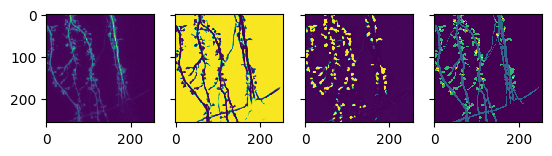

In [5]:

import sys
sys.path.append(".")
import torch
from train.networks import unetplusplus
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from utils.yaml_config import YAMLConfig
from glob import glob
from utils import file_base, yaml_config
def showtwo(*ims):
    fig,axes=plt.subplots(1,len(ims),sharex=True,sharey=True)
    # print(im1.shape)
    for i,im in enumerate(ims):
        axes[i].imshow(im,interpolation='none')
    # axes[1].imshow(im2,interpolation='none')
    # axes[2].imshow(im3,interpolation='none')
    plt.show()

num_classes=3
from utils.file_base import file_list
import colorsys
from PIL import Image
import torch
from torchvision.transforms import ToTensor

# model=unetplusplus.UNet2d(3,1)
# model.layer_num=3
model=predictmodel.model
model.to("cpu")

# modelpath=r"D:\code\test-dataset\model\2Dtorchunet-b/seg\ep003-loss0.415.pth"
# model.load_state_dict(torch.load(modelpath))
model.eval()
imgdir=r"D:\code\test-dataset\Train\2D\seg\img"
configfile=r"../config\defalut_2d_border.yaml"
default_configuration=YAMLConfig(
    configfile
    )
network_info=default_configuration.config["Network"]
model.load_network_set(network_info)
#---------------------------------------------------#
#   创建一副新图，并根据每个像素点的种类赋予颜色
#---------------------------------------------------#
# imglist=file_list(imgdir)
# imglist=[
#     r"D:\data\Train\2Dimg_seg\test\img\2.tif",
# r"D:\data\Train\2Dimg_seg\test\img\4.tif",
# r"D:\data\Train\2Dimg_seg\test\img\1.tif",
# ]
datafolder=r'E:\data\Train\Train\2D-2023-border\test'
imgfiles = glob(datafolder+'\\img\\*.tif')
labelfiles = glob(datafolder+'\\label\\*.tif')
pairs=file_base.pair_files(imgfiles,labelfiles,suffix="-border")
print(len(pairs))
for imgc,lab in pairs:
   # print(img)
    # img=r"D:\code\test-dataset\Train\2D\seg\img\202111-1.tif"
    lab=imread(lab)
    imgc=imread(imgc).astype("float32")
    ypred=model.predict_2d_img(imgc)
    
    # outputs = torch.argmax(ypred, dim=1).data.numpy()
    # outputs=np.squeeze(outputs)
    # print(outputs.shape)
    showtwo(imgc,ypred[0].data.numpy(),ypred[-1].data.numpy(),lab)
    break

In [8]:
#--- Predict ---#
from csbdeep.utils import normalize
from spinelib.seg import unetseg

model=predictmodel.model
# print(img.shape)
# img=normalize(img)
mask,spinepr,denpr,bgpr=unetseg.predict_single_img(model,img)

spine_label=unetseg.instance_unetmask_bypeak(spinepr,mask,searchbox,min_radius,spinesize_range=[4,800])
# spine_label=unetseg.instance_unetmask_by_border(spinepr,mask==2,bgpr,0.005,spinesize_range=[4,800])
# mask=segment.modify_mask(mask,sizeth=spine_min_size_th)

In [9]:
#--- View  Predict Result ---#
viewer=imgio.plot.imshow3d(I=img,
    Is_overlay=[spinepr,denpr,bgpr],
    name_Is=[   "spinepr","denpr","bgpr"],
    cmap_Is=[   "magenta",  "green","gray"],
    label_lay=[mask,spine_label],
    label_lay_name=["mask","spine"]   )


In [1]:
import napari
from skimage.io import imread
filename=r"E:\code\新建文件夹\Stablized tboaltp20180128n3-1\Stablized tboaltp20180128n3-1.tif"
im=imread(filename)
v=napari.Viewer()
v.add_image(im)

<Image layer 'im' at 0x266d12dc940>

In [ ]:
# if mask is not correct ,custom run it

##!!-------------!!!##
#  th for spine_pr  #
##!!------------!!!##
spine_pr_th=0.07
den_pr_th=0.1

mask[local_threshold(denpr,15)]=1
mask[local_threshold(spinepr,15)]=2

In [ ]:
img.shape

In [ ]:
# spine instance segment result and modify

pr_corner=peakfilter(spinepr,min_radius,0,use_gaussian=True)*(mask==2)#*adth
spine_label=segment.label_instance_water(spinepr,pr_corner,mask==2, 
                                maxspinesize,searchbox=searchbox)

##!!-------------!!!##
#  min_size  #
##!!------------!!!##
spine_label=remove_small_objects(spine_label,min_size=4)

old_spine=spine_label

In [ ]:
# correct final spine instance segment result

##%%---------- ----------%%##
# need edit , edit label
##%%---------- ----------%%##
# spine_label=imgio.ski_imread(r"D:\data\Train\2D\result2\20200319-2\20200319-2-spine.tif")
# mask=imgio.ski_imread(r"D:\data\Train\2D\result2\20200319-2\20200319-2-mask.tif")

# mask=np.zeros_like(spine_label)
# mask[spine_label==1]=1
# mask[spine_label>1]=2
# spine_label[spine_label==1]=0
viewer=imgio.plot.imshow3d(I=img,Is_overlay=[ spinepr,denpr],
    name_Is=[   "spinepr","denpr"],
    label_lay=[mask,spine_label],
    label_lay_name=["mask","label"]   )
spine_label=viewer.layers["label"].data
spine_label,_=segment.resortseg(spine_label,2)

In [ ]:
# save result
# save img
mask[mask==2]=0
mask[spine_label>0]=2

imsave(imgfile,img)
print("save :",imgfile)
# save pr
# savepr(spinepr,spineprfile)
# savepr(denpr,denprfile)
# save lebel
savelabel(mask,maskfile)
# spine_label[mask==2]=1
savelabel(spine_label,spinefile)
savelabel(mask==1,denfile)
news=spine_label.copy()
news[mask==1]=1
savelabel(news,segfile)


if ndim==3:
    imsave(zimgfile,np.max(img,axis=0))
    zden=np.max(mask==1,axis=0)
    zspine=np.max(spine_label,axis=0)
    zspine[zden]=1
    savelabel(zden,zdenfile)
    savelabel(zspine,zspinefile)
    zspine[zspine>1]=2
    savelabel(zspine,zmaskfile)

# Part Two 
please jump to single_frame_2D_3D_statics.pynb


In [ ]:
# save csv
# row : id,[centroid-z,],centeroid/x,centerid/y,area/volume,mean intensity,length,head-diameter,perimeter/suface/area,rotate-mask

import pandas as pd
from spinelib.utils import measure
from skimage.measure import label, regionprops, regionprops_table

#load data
spinefile=r"I:\data\Train\test\0319seg-new-thin.tif"
imgfile=r"I:\data\Train\test\20200319-1.tif"
savedir=r"I:\data\Train\test\0319-result"
areafile=r"I:\data\Train\test\0319-result\0319-info.scv"
areafile=r"I:\data\Train\test\0319-result\0319-info.scv"
skeletonfile=r"I:\data\Train\test\0319-result\0319-trace.tif"
file_base.create_dir(savedir)

img=imgio.ski_imread(imgfile)
spine_label=imgio.ski_imread(spinefile)

# length and head and individual rotate-mask
lables_dict=measure.label_statics(img,spine_label)
corddict,linemask=spines_distance(img,spine_label,[20,20])
# centroid,traces,length,headlength,mask=
# cords : dict[lab] = (centroid , path from den to spine bound),length,headlength,spinemask

labs=set(np.unique(spine_label))
i=0
for lab in labs:
    i+=1
    # if i>20: break
    if lab==1: continue
    if lab not in corddict: continue
    cords,length,headlength,attach_cnt,rotamask=corddict[lab]
    lables_dict[lab].append(length)
    lables_dict[lab].append(headlength)
    lables_dict[lab].append(attach_cnt)
    if rotamask is None: continue
    savelabel(rotamask,os.path.join(savedir,str(lab)+"-ID-mask.tif"))

df=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in lables_dict.items()]))
ndim=img.ndim
if ndim==3:
    df.rename(columns={0:'bg',1:'den'},index={0:"centroidz",1:"centroidy",2:"centroidx",3:"Area/Volume",4:"mean-intensity",5:"length",6:"headlength",7:"attach-den"},inplace=True)
else:   
    df.rename(columns={0:'bg',1:'den'},index={0:"centroidy",1:"centroidx",2:"Area/Volume",3:"mean-intensity",4:"length",5:"headlength",6:"attach-den"},inplace=True)

# save csv result
df.to_csv(areafile)
savelabel(linemask,skeletonfile)
print("save :",areafile)



In [ ]:
df

In [ ]:
# plot images scattet plot

from scipy import ndimage
import matplotlib.pyplot as plt
figsize=(15,7)
fontsize=20
radm=60
def plot_scatter(x,y,z,s):
    fig = plt.figure(figsize = figsize)  
    ax = plt.axes()  
    # Creating a plot using the random datasets   
    ax.set_xlabel('length /μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_ylabel('head /μm', fontweight ='normal',fontsize=fontsize)  
    # ax.set_zlabel('attach', fontweight ='bold') 
    cmap=plt.get_cmap('viridis')
    # cmap=plt.cm.Spectral
    # print(x.shape,y.shape,z.shape)
    # z=np.array(z).ravel()
    # norm = plt.Normalize(vmin=np.nanmin(z)-1, vmax=np.nanmax(z)-1)
    # vmax=np.nanmax(z)
    # alpha=norm(z)
    # alpha[np.isnan(alpha)]=0
    norm = plt.Normalize(vmin=np.nanmin(s)-0.16, vmax=np.nanmax(s)-0.16)
    # s=30*(vmax-z)
    sctt=ax.scatter(x, y, c=z,s=radm*norm(s),cmap=cmap,alpha=0.8)  
    cbar=fig.colorbar(sctt, ax = ax, shrink = 0.6, aspect = 5)
    cbar.ax.set_title('neck/μm',fontsize=fontsize)
    ax.set_xlim(0,4)
    ax.set_ylim(0,2.5)
    xlables=ax.get_xticks()
    ylables=ax.get_yticks()
    ax.set_xticklabels(xlables,fontsize=15)
    ax.set_yticklabels(ylables,fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title("2D scatter") 
def plot_scatter3D(x,y,z,s):
    fig = plt.figure(figsize = figsize)  
    ax = plt.axes(projection ="3d")  
    # Creating a plot using the random datasets   
    ax.set_xlabel('length /μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_ylabel('head /μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_zlabel('neck /μm', fontweight ='normal',fontsize=fontsize) 
    
    cmap=plt.get_cmap('viridis')
    # cmap=plt.cm.Spectral
    print(x.shape,y.shape,z.shape)

    # norm = plt.Normalize(vmin=np.min(z), vmax=np.max(z))
    norm = plt.Normalize(vmin=np.nanmin(s)-1, vmax=np.nanmax(s)-1)
    sctt=ax.scatter3D(x, y, z,c=z,s=radm/3*norm(s),cmap=cmap,alpha=0.8)  
    cbar=fig.colorbar(sctt, ax = ax, shrink = 0.6, aspect = 5)
    cbar.ax.set_title('neck/μm',fontsize=fontsize)
    plt.title("3D scatter plot")
def plot_images_at_cords(images,oys,oxs,maxsize,zoom=1.0):
    # if maxsize smaller than any images, 
    # remove nan
    xs=oxs[~ np.isnan(oxs)]
    ys=oys[~ np.isnan(oys)]
    xs=np.sort(np.unique(xs))
    print(xs)
    ys=np.sort(np.unique(ys))
    min_spacex=np.min(xs[1:]-xs[0:-1]) 
    min_spacey=np.min(ys[1:]-ys[0:-1])
    xlim=[xs[0],xs[-1]]
    ylim=[ys[0],ys[-1]]
    ratiox=maxsize[0]/min_spacex
    ratioy=maxsize[1]/min_spacey
    print(min_spacex,min_spacey,xlim,ylim)
    canvassize=[maxsize[0]*int((xlim[1]-xlim[0])/min_spacex+3),
                maxsize[1]*int((ylim[1]-ylim[0])/min_spacey+3)]
    canvas=np.ones(canvassize)*255
    for im,x,y in zip(images,oxs,oys):
        if np.isnan(x) or np.isnan(y) or im is None:
            continue
        cropcanvas=np.zeros_like(maxsize)
        # check imagesize
        im=im.copy()
        im[im>0]=125
        im[im==0]=255
        im=ndimage.zoom(im,zoom)
        imshape=im.shape
        x=xlim[1]-x
        y=y-ylim[0]
        bx=int(x*ratiox-imshape[0]/2)+maxsize[0]
        by=int(y*ratioy-imshape[1]/2)+maxsize[1]
        canvas[bx:bx+imshape[0],by:by+imshape[1]]=im
    fig = plt.figure(figsize =figsize) 
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.imshow(canvas,cmap="gray")
    # xlables=ax.get_xticks()
    # ylables=ax.get_yticks()
    # ax.set_xticklabels([round((y-maxsize[1])/ratioy+ylim[0],2) for y in xlables],fontsize=15)
    # ax.set_yticklabels([round(xlim[1]-(x-maxsize[0])/ratiox,2) for x in ylables],fontsize=15)
    print([round(i*ratiox,0) for i in np.arange(0,3,0.5)])
    ax.set_yticks([round(i*ratiox,0) for i in np.arange(2.5,-0.5,-0.5)])
    ax.set_xticks([round(i*ratioy,0) for i in np.arange(0,4.5,0.5)])
    ax.set_yticklabels(np.arange(0,3,0.5),fontsize=15)
    ax.set_xticklabels(np.arange(0,4.5,0.5),fontsize=15)
    ax.set_xlabel('length/μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_ylabel('head/μm', fontweight ='normal',fontsize=fontsize)  
    print()

      
        
    

In [ ]:
# plot images scattet plot

from scipy import ndimage
import matplotlib.pyplot as plt
figsize=(15,7)
fontsize=20
radm=60
def plot_scatter(x,y,z,s):
    fig = plt.figure(figsize = figsize)  
    ax = plt.axes()  
    # Creating a plot using the random datasets   
    ax.set_xlabel('length /μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_ylabel('head /μm', fontweight ='normal',fontsize=fontsize)  
    # ax.set_zlabel('attach', fontweight ='bold') 
    cmap=plt.get_cmap('viridis')
    # cmap=plt.cm.Spectral
    # print(x.shape,y.shape,z.shape)
    # z=np.array(z).ravel()
    # norm = plt.Normalize(vmin=np.nanmin(z)-1, vmax=np.nanmax(z)-1)
    # vmax=np.nanmax(z)
    # alpha=norm(z)
    # alpha[np.isnan(alpha)]=0
    norm = plt.Normalize(vmin=np.nanmin(s)-0.16, vmax=np.nanmax(s)-0.16)
    # s=30*(vmax-z)
    sctt=ax.scatter(x, y, c=z,s=radm*norm(s),cmap=cmap,alpha=0.8)  
    cbar=fig.colorbar(sctt, ax = ax, shrink = 0.6, aspect = 5)
    cbar.ax.set_title('neck/μm',fontsize=fontsize)
    ax.set_xlim(0,4)
    ax.set_ylim(0,2.5)
    xlables=ax.get_xticks()
    ylables=ax.get_yticks()
    ax.set_xticklabels(xlables,fontsize=15)
    ax.set_yticklabels(ylables,fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title("2D scatter") 
def plot_scatter3D(x,y,z,s):
    fig = plt.figure(figsize = figsize)  
    ax = plt.axes(projection ="3d")  
    # Creating a plot using the random datasets   
    ax.set_xlabel('length /μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_ylabel('head /μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_zlabel('neck /μm', fontweight ='normal',fontsize=fontsize) 
    
    cmap=plt.get_cmap('viridis')
    # cmap=plt.cm.Spectral
    print(x.shape,y.shape,z.shape)

    # norm = plt.Normalize(vmin=np.min(z), vmax=np.max(z))
    norm = plt.Normalize(vmin=np.nanmin(s)-1, vmax=np.nanmax(s)-1)
    sctt=ax.scatter3D(x, y, z,c=z,s=radm/3*norm(s),cmap=cmap,alpha=0.8)  
    cbar=fig.colorbar(sctt, ax = ax, shrink = 0.6, aspect = 5)
    cbar.ax.set_title('neck/μm',fontsize=fontsize)
    plt.title("3D scatter plot")
def plot_images_at_cords(images,oys,oxs,zs,labs,maxsize,zoom=1.0):
    # if maxsize smaller than any images, 
    # remove nan
    xs=oxs[~ np.isnan(oxs)]
    ys=oys[~ np.isnan(oys)]
    xs=np.sort(np.unique(xs))
    print(xs)
    ys=np.sort(np.unique(ys))
    min_spacex=np.min(xs[1:]-xs[0:-1]) 
    min_spacey=np.min(ys[1:]-ys[0:-1])
    xlim=[xs[0],xs[-1]]
    ylim=[ys[0],ys[-1]]
    ratiox=maxsize[0]/min_spacex
    ratioy=maxsize[1]/min_spacey
    print(min_spacex,min_spacey,xlim,ylim)
    canvassize=[maxsize[0]*int((xlim[1]-xlim[0])/min_spacex+3),
                maxsize[1]*int((ylim[1]-ylim[0])/min_spacey+3)]
    canvas=np.ones(canvassize)*np.nan
    cnts={1:0,2:0,3:0,4:0,5:0}
    nms={}
    for im,x,y,z,lab in zip(images,oxs,oys,zs,labs):
        if np.isnan(x) or np.isnan(y) or im is None:
            continue
        cropcanvas=np.zeros_like(maxsize)
        # check imagesize
        im=np.array(im>0,dtype="float")
        v=5
        LW=y/z
        LH=x/z
        if LW<2: 
            if LH<1.5:
                v=1 #s
            elif LH<3:
                v=2 #m
            else:
                v=1
        elif LW<5:
            if LH<1.5:
                v= 3# t
            else:
                v=2
        else:
            if LH<3:
                v=3
            else:
                v=2 
                
        nms[lab]=v
        im[im>0]=v
        im[im==0]=np.nan
        cnts[v]+=1
        # im=ndimage.zoom(im,zoom)
        imshape=im.shape
        x=xlim[1]-x
        y=y-ylim[0]
        bx=int(x*ratiox-imshape[0]/2)+maxsize[0]
        by=int(y*ratioy-imshape[1]/2)+maxsize[1]
        if np.isnan(canvas[bx:bx+imshape[0],by:by+imshape[1]]).all(): 
            canvas[bx:bx+imshape[0],by:by+imshape[1]][im>0]=im[im>0]
    print("uni",np.unique(canvas),cnts)
    fig = plt.figure(figsize =figsize) 
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.imshow(canvas,cmap="tab20c",vmin=0,vmax=5,interpolation='nearest',interpolation_stage="rgba")
    # xlables=ax.get_xticks()
    # ylables=ax.get_yticks()
    # ax.set_xticklabels([round((y-maxsize[1])/ratioy+ylim[0],2) for y in xlables],fontsize=15)
    # ax.set_yticklabels([round(xlim[1]-(x-maxsize[0])/ratiox,2) for x in ylables],fontsize=15)
    print([round(i*ratiox,0) for i in np.arange(0,3,0.5)])
    ax.set_yticks([round(i*ratiox,0) for i in np.arange(2.5,-0.5,-0.5)])
    ax.set_xticks([round(i*ratioy,0) for i in np.arange(0,4.5,0.5)])
    ax.set_yticklabels(np.arange(0,3,0.5),fontsize=15)
    ax.set_xticklabels(np.arange(0,4.5,0.5),fontsize=15)
    ax.set_xlabel('length/μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_ylabel('head/μm', fontweight ='normal',fontsize=fontsize)  
    print()
    return nms

      
        
    

In [ ]:
A=df.iloc[[2],2:]*0.16*0.16
x=df.iloc[[4],2:]*0.16
y=df.iloc[[5],2:]*0.16
z=df.iloc[[6],2:]*0.16
A=np.array(A).ravel()
x=np.array(x).ravel()
y=np.array(y).ravel()
z=np.array(z).ravel()
%matplotlib inline 
labs=np.array(df.columns[2:])
ms=[corddict[lab][-1] if lab in corddict else None for lab in labs]
nms=plot_images_at_cords(ms,x,y,z,labs,[20,20],zoom=1.0) 
plot_scatter(x,y,z,s=A)
plot_scatter3D(x,y,z,s=A)

In [ ]:
spine_label_c=np.zeros_like(spine_label)
for k,v in nms.items():
    spine_label_c[spine_label==k]=v
    spine_label_c[linemask==k]=v
viewer=imgio.plot.imshow3d(I=img,
    label_lay=[spine_label_c,spine_label],
    label_lay_name=["mask","label"]   )

In [ ]:
from spinelib.utils.spine_struct import spines_distance,spine_distance
from spinelib.utils.distance_transform import get_weighted_distance_transform
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
# cropimg[croplable==lab]=0
img=imgio.ski_imread(imgfile)
weightimg=1+(np.max(img)-img)/100
weightimg=np.array(weightimg*weightimg,dtype="uint16")
lab=17
searchbox=[25,25]
plt.figure(figsize=(6,24))
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(24,24))
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.axis('image')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

inds=np.argwhere(spine_label==lab)
shape=spine_label.shape
centroid=np.mean(inds,axis=0)
bindbox=[slice(
    np.min(inds[:,i])-searchbox[i],
    np.max(inds[:,i])+searchbox[i],) 
            for i in range(spine_label.ndim)]
cropimg=img[bindbox].copy()
croplable=spine_label[bindbox].copy()
linemaskcrop=linemask[bindbox].copy()
cropweight=weightimg[bindbox].copy()
cropweight[croplable==lab]=0
axs[0].imshow(cropimg,cmap="gray",vmax=np.max(cropimg)*0.6)

# croplable=croplable[bindbox].copy()
# cropimg=cropimg[bindbox].copy()

cropimg[croplable==lab]=0
distance_transform=get_weighted_distance_transform(cropweight)
linemaskcrop[linemaskcrop!=lab]=0
# distance_transform[linemaskcrop>0]=np.nan
distance_transform[croplable==lab]=np.nan
tms=np.zeros_like(croplable)
tms[croplable==1]=1
# tms[croplable==lab]=1
# axs[1].imshow(croplable,cmap="gray")
cmap=plt.get_cmap('viridis')
cmap.set_bad(color="whitw")
axs[1].imshow(distance_transform)
contours = measure.find_contours(tms, 0.2,fully_connected="high")

for contour in contours:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2,color="k")
ps=np.where(linemaskcrop==lab)
axs[1].plot(ps[1],ps[0], linewidth=3,color="gray")



croplable[croplable!=lab]=0
croplable[linemaskcrop==lab]=lab
axs[2].imshow(lab-croplable,cmap="gray")

ps=np.argwhere(croplable)

mins=np.min(ps,axis=0)
maxs=np.max(ps,axis=0)
wids=int((np.max(maxs-mins)+1)/2)
mids=np.array((mins+maxs)/2,dtype="int")


bindbox=[slice(max(mids[i]-wids,0), min(mids[i]+wids,croplable.shape[i]))   for i in range(ndim)]
axs[0].plot(
            [bindbox[1].start,bindbox[1].stop,bindbox[1].stop,bindbox[1].start,bindbox[1].start], 
            [bindbox[0].start,bindbox[0].start,bindbox[0].stop,bindbox[0].stop,bindbox[0].start ] , 
            linewidth=2,color="white")





In [ ]:
from spinelib.utils.spine_struct import spines_distance,spine_distance
from spinelib.utils.distance_transform import get_weighted_distance_transform
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
# cropimg[croplable==lab]=0
img=imgio.ski_imread(imgfile)
weightimg=1+(np.max(img)-img)/100
weightimg=np.array(weightimg*weightimg,dtype="uint16")
lab=17
searchbox=[25,25]
plt.figure(figsize=(6,24))
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(24,24))
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.axis('image')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

inds=np.argwhere(spine_label==lab)
shape=spine_label.shape
centroid=np.mean(inds,axis=0)
bindbox=[slice(
    np.min(inds[:,i])-searchbox[i],
    np.max(inds[:,i])+searchbox[i],) 
            for i in range(spine_label.ndim)]
cropimg=img[bindbox].copy()
croplable=spine_label[bindbox].copy()
linemaskcrop=linemask[bindbox].copy()
cropweight=weightimg[bindbox].copy()
cropweight[croplable==lab]=0


axs[0].imshow(cropimg,cmap="gray",vmax=np.max(cropimg)*0.6)

tms=np.zeros_like(croplable)
tms[croplable==lab]=lab
tms[linemaskcrop==lab]=lab
ps=np.argwhere(tms==lab)

mins=np.min(ps,axis=0)
maxs=np.max(ps,axis=0)
wids=int((np.max(maxs-mins)+1)/2)
mids=np.array((mins+maxs)/2,dtype="int")


bindbox=[slice(max(mids[i]-wids-2,0), min(mids[i]+wids+2,croplable.shape[i]))   for i in range(ndim)]
axs[0].plot(
            [bindbox[1].start,bindbox[1].stop,bindbox[1].stop,bindbox[1].start,bindbox[1].start], 
            [bindbox[0].start,bindbox[0].start,bindbox[0].stop,bindbox[0].stop,bindbox[0].start ] , 
            linewidth=2,color="white")


croplable=croplable[bindbox].copy()
cropimg=cropimg[bindbox].copy()
cropweight=cropweight[bindbox].copy()
linemaskcrop=linemaskcrop[bindbox].copy()
cropimg[croplable==lab]=0
distance_transform=get_weighted_distance_transform(cropweight)
linemaskcrop[linemaskcrop!=lab]=0
# distance_transform[linemaskcrop>0]=np.nan
distance_transform[croplable==lab]=np.nan
# distance_transform=distance_transform[bindbox].copy()
tms=np.zeros_like(croplable)
tms[croplable==1]=1
# tms[croplable==lab]=1
# axs[1].imshow(croplable,cmap="gray")
cmap=plt.get_cmap('viridis')
cmap.set_bad(color="k")
axs[1].imshow(distance_transform)
contours = measure.find_contours(tms, 0.2,fully_connected="high")

for contour in contours:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2,color="k")
ps=np.where(linemaskcrop==lab)
axs[1].plot(ps[1],ps[0], linewidth=3,color="gray")



croplable[croplable!=lab]=0
croplable[linemaskcrop==lab]=lab
axs[2].imshow(lab-croplable,cmap="gray")





